This jupyter notebook tries to predict solar flares in the next day based on the last N days using recurrent neural networks (RNN, more especifically GRU) for binary (flare or not) classification.
It is divided in 4 parts:
* Loading libraries and data.
* Transforming the dataset and doing some feature engineering.
* Making and fiting the model.
* Checking the results.

# Forecasting solar flares using recurrent neural networks (RNN) for classification
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import AUC, Precision, Recall

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               4480 non-null   object 
 1   USFLUX             4480 non-null   float64
 2   MEANGAM            4480 non-null   float64
 3   MEANGBT            4480 non-null   float64
 4   MEANGBZ            4480 non-null   float64
 5   MEANGBH            4480 non-null   float64
 6   MEANJZD            4480 non-null   float64
 7   TOTUSJZ            4480 non-null   float64
 8   MEANALP            4480 non-null   float64
 9   MEANJZH            4480 non-null   float64
 10  TOTUSJH            4480 non-null   float64
 11  ABSNJZH            4480 non-null   float64
 12  SAVNCPP            4480 non-null   float64
 13  MEANPOT            4480 non-null   float64
 14  TOTPOT             4480 non-null   float64
 15  MEANSHR            4480 non-null   float64
 16  SHRGT45            4480 

# Changing the dataframe to fit RNN
***

In [3]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   DATE               4480 non-null   datetime64[ns, UTC]
 1   USFLUX             4480 non-null   float64            
 2   MEANGAM            4480 non-null   float64            
 3   MEANGBT            4480 non-null   float64            
 4   MEANGBZ            4480 non-null   float64            
 5   MEANGBH            4480 non-null   float64            
 6   MEANJZD            4480 non-null   float64            
 7   TOTUSJZ            4480 non-null   float64            
 8   MEANALP            4480 non-null   float64            
 9   MEANJZH            4480 non-null   float64            
 10  TOTUSJH            4480 non-null   float64            
 11  ABSNJZH            4480 non-null   float64            
 12  SAVNCPP            4480 non-null   float64      

In [4]:
# Analyze flare distribution over time
# Number of flare-days per year
df_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum'])
print(df_flares)

        sum
DATE       
2010    8.0
2011   65.0
2012   79.0
2013   68.0
2014  118.0
2015   68.0
2016   11.0
2017   15.0
2018    0.0
2019    0.0
2020    2.0
2021   21.0
2022   92.0
2023    8.0


In [5]:
# Number of days with flares (count should be 365 or 366 for leap years)
# values below 365(6) indicate some missing data
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with flare distribution by year:")
print(yearly_flares)


Days with flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [6]:
# chronological split is important for time series, so let's sort by DATE
df = df.sort_values('DATE').reset_index(drop=True)
assert df['DATE'].is_monotonic_increasing

print(df.head())

                       DATE        USFLUX    MEANGAM     MEANGBT     MEANGBZ  \
0 2010-05-01 00:00:00+00:00  2.325578e+21  29.580376  121.361911  123.196711   
1 2010-05-02 00:00:00+00:00  2.699988e+21  28.754651  122.189762  122.241274   
2 2010-05-03 00:00:00+00:00  2.737004e+21  32.654695  114.207593  116.857353   
3 2010-05-04 00:00:00+00:00  3.460735e+21  29.845298  111.707230  113.253585   
4 2010-05-05 00:00:00+00:00  4.497098e+21  32.732238  114.995095  116.684410   

     MEANGBH   MEANJZD       TOTUSJZ   MEANALP   MEANJZH  ...     xrs_B_max  \
0  51.438868  0.322770  2.560842e+12 -0.003638 -0.001203  ...  5.723020e-06   
1  49.093493  0.482670  2.708962e+12 -0.007883 -0.001898  ...  3.839320e-07   
2  50.317212  0.219577  3.095129e+12 -0.002852 -0.000701  ...  2.017300e-07   
3  47.297438  0.145063  3.903967e+12 -0.015477 -0.005461  ...  3.672410e-06   
4  53.376813  0.285346  5.270056e+12 -0.019851 -0.008012  ...  1.280620e-05   

   Radio Flux 10.7cm  Sunspot Number  Sunspo

# Fitting the model
***

In [7]:
# let's check all columns to drop some (in the features) on the next cell
print(df.columns)

Index(['DATE', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'R_VALUE', 'xrs_A_mean',
       'xrs_A_min', 'xrs_A_max', 'xrs_B_mean', 'xrs_B_min', 'xrs_B_max',
       'Radio Flux 10.7cm', 'Sunspot Number', 'Sunspot Area', 'New Regions',
       'Flares: C', 'Flares: M', 'Flares: X', 'flare_today', 'flare_missing'],
      dtype='object')


In [8]:
# Separate features and target
# I started using the Flares: C/M/X features, and it is very useful, but it may leak information from the future.
# DATE may not be a problem or leak information, but I am excluding it just to be sure
feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today', 'Flares: C', 'Flares: M', 'Flares: X']] 
#feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today']] 
X = df[feature_cols].values
y = df['flare_today'].values

In [9]:
# Checking feature names
print(df[feature_cols].columns)

Index(['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'R_VALUE', 'xrs_A_mean',
       'xrs_A_min', 'xrs_A_max', 'xrs_B_mean', 'xrs_B_min', 'xrs_B_max',
       'Radio Flux 10.7cm', 'Sunspot Number', 'Sunspot Area', 'New Regions',
       'flare_missing'],
      dtype='object')


In [10]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# This function will transform the 2D data (X) into a 3D array with the shape: 
# [number_of_samples, N_timesteps, number_of_features]
def create_sequences(X, y, time_steps):
    """
    Transforms 2D data into 3D sequences for RNN/GRU input.

    X: 2D array of features (all time steps)
    y: 1D array of targets (all time steps)
    time_steps: The lookback window (N)
    """
    Xs, ys = [], []
    # Loop starts at 'time_steps' to ensure the first sequence is complete.
    # The sequence X[i-time_steps:i] (N historical points) predicts y[i] (the next point).
    for i in range(time_steps, len(X)):
        # Input sequence: data from time t-N up to t-1
        Xs.append(X[i-time_steps:i])
        # Target: data at time t (what we are predicting)
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# lookback window of N hours
time_steps = 3 

X_sequences, y_targets = create_sequences(X_scaled, y, time_steps)

# Check the new shape
print(X_sequences.shape) # Should look like (244532, N, 17)
print(y_targets.shape)   # Should look like (244532,)

(4477, 3, 28)
(4477,)


In [12]:
# Split into train and test sets

# Use last 20% as test set and NO RANDOM SPLIT FOR TIME SERIES
split_idx = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
y_train, y_test = y_targets[:split_idx], y_targets[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 3581
Test samples: 896

Class distribution in training set:
Percentage of positive cases in train: 12.09%

Class distribution in test set:
Percentage of positive cases in test: 13.62%


In [13]:
# Get the final feature count and time steps for the model input layer
n_features = X_train.shape[2]
time_steps = X_train.shape[1]

In [14]:
# you can just load the model if already trained and not run the grid search and best model again
try:
    model = load_model('./Data/flares_keras_RNN.keras')
except:
    print("No saved model found, proceeding to train a new model.")

No saved model found, proceeding to train a new model.


In [15]:
# Function to create the GRU model
def create_model(n_features, time_steps, units_gru, units_dense, dropout_rate, learning_rate):

    """Create model with configurable hyperparameters"""
    model = Sequential([
            # 0. Input Layer
            Input(shape=(time_steps, n_features)),

            # 1. Sequential Layer (GRU)
            GRU(units=units_gru, activation='tanh', return_sequences=False),
            Dropout(dropout_rate),
            
            # 2. Classification Layer (Dense)
            Dense(units=units_dense, activation='relu'),
            Dropout(dropout_rate),
            
            # 3. Output Layer
            Dense(units=1, activation='sigmoid')
        ])
        
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='binary_crossentropy',
        metrics=[AUC(name='AUC'), Precision(name='Precision'), Recall(name='Recall')]
    )
    return model

In [16]:
# Function to create the randomized search for hyperparameter tuning
def randomized_search(X_train, y_train, n_iter=20):
    """Random search over hyperparameters"""
    
    # Define hyperparameter ranges
    param_distributions = {
        'units_gru': [32, 64, 128, 256],
        'units_dense': [16, 32, 64],
        'dropout_rate': [0.1, 0.3, 0.5],
        'learning_rate': [1e-3, 5e-4, 1e-4],
        #'time_steps': [3, 6, 12, 24],
        'time_steps': [3],
        'batch_size': [32, 64, 128]
    }
    
    # support both 2D and 3D inputs
    if X_train.ndim == 3:
        n_samples, time_steps_from_X, n_features = X_train.shape
    else:
        n_samples, n_features = X_train.shape
        time_steps_from_X = None
    
    # Compute class weights for imbalanced dataset
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )))
    
    best_score = 0
    best_params = {}
    results = []
    
    print(f"Testing {n_iter} random combinations...")
    
    for i in range(n_iter):
        # Random sample from each parameter distribution
        params = {
            'units_gru': int(np.random.choice(param_distributions['units_gru'])),
            'units_dense': int(np.random.choice(param_distributions['units_dense'])),
            'dropout_rate': float(np.random.choice(param_distributions['dropout_rate'])),
            'learning_rate': float(np.random.choice(param_distributions['learning_rate'])),
            'time_steps': int(np.random.choice(param_distributions['time_steps'])),
            'batch_size': int(np.random.choice(param_distributions['batch_size']))
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing: {params}")
        
        # If X_train already has time_steps dimension, ensure consistency
        if time_steps_from_X is not None and params['time_steps'] != time_steps_from_X:
            # skip incompatible combinations
            print(f"  -> Skipping params because X_train.time_steps={time_steps_from_X} != sampled time_steps={params['time_steps']}")
            continue
        
        # Create model (exclude batch_size from model creation)
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(n_features=n_features, **model_params)
        
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0,
            class_weight=class_weights
        )
        
        # Get best validation AUC (defensive access)
        val_auc = max(history.history.get('val_AUC', [0]))
        print(f"  -> Val AUC: {val_auc:.4f}")
        
        # Store results
        results.append({**params, 'val_auc': val_auc})
        
        # Update best
        if val_auc > best_score:
            best_score = val_auc
            best_params = params
    
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"  Best Validation AUC: {best_score:.4f}")
    
    return best_params, best_score, results

In [17]:
# Search for the best hyperparameters
best_params, best_score, results = randomized_search(
    X_train, 
    y_train, 
    n_iter=50
)

Testing 50 random combinations...

[1/50] Testing: {'units_gru': 128, 'units_dense': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'time_steps': 3, 'batch_size': 64}
  -> Val AUC: 0.3694

[2/50] Testing: {'units_gru': 256, 'units_dense': 16, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'time_steps': 3, 'batch_size': 32}
  -> Val AUC: 0.3247

[3/50] Testing: {'units_gru': 32, 'units_dense': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'time_steps': 3, 'batch_size': 128}
  -> Val AUC: 0.5098

[4/50] Testing: {'units_gru': 64, 'units_dense': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'time_steps': 3, 'batch_size': 64}
  -> Val AUC: 0.2863

[5/50] Testing: {'units_gru': 32, 'units_dense': 16, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'time_steps': 3, 'batch_size': 128}
  -> Val AUC: 0.5824

[6/50] Testing: {'units_gru': 256, 'units_dense': 16, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'time_steps': 3, 'batch_size': 64}
  -> Val AUC: 0.2486

[7/50] Testing: {'units_g

In [18]:
# Create the final model with best parameters
model = Sequential([
    Input(shape=(time_steps, n_features)),
    GRU(best_params['units_gru'], activation='tanh'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_dense'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

In [19]:
# Compile with best learning rate
model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

In [20]:
# Compute class weights for imbalanced dataset
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

In [21]:
# Train the best model
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.4379 - Precision: 0.1253 - Recall: 0.3218 - loss: 0.8229 - val_AUC: 0.2807 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.6869
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5771 - Precision: 0.1877 - Recall: 0.5069 - loss: 0.7580 - val_AUC: 0.2926 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.6189
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6975 - Precision: 0.2374 - Recall: 0.6782 - loss: 0.7021 - val_AUC: 0.2891 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5608
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7413 - Precision: 0.2636 - Recall: 0.7384 - loss: 0.6809 - val_AUC: 0.2758 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5099
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7992 - Precision: 0.2790 - Recall: 0.8009 - loss: 0.6325 - val_AUC: 0.2577 - val_Precision: 0.0000e+00 - val_Recall:

In [22]:
# evaluate
results = model.evaluate(X_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.44456735253334045, 'compile_metrics': 0.33442622423171997}


In [23]:
# Save the best model
model.save("../data/flares_keras_RNN.keras")
print("Best model saved to ../data/flares_keras_RNN.keras")

Best model saved to ../data/flares_keras_RNN.keras


In [24]:
# Predict
y_pred_proba = model.predict(X_test).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


# Results
***

In [25]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2_score, f1_score, recall, avg_precision, roc_auc]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


Confusion Matrix:
[[571 203]
 [ 20 102]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84       774
         1.0       0.33      0.84      0.48       122

    accuracy                           0.75       896
   macro avg       0.65      0.79      0.66       896
weighted avg       0.88      0.75      0.79       896


Evaluation Metrics:
       Metric  Score
           F2 0.6431
           F1 0.4778
       Recall 0.8361
Avg Precision 0.5436
      ROC AUC 0.8551


In [26]:
# Analyze different classification thresholds
print("\nThreshold Analysis:")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold Analysis:

Threshold = 0.3
  TP: 107, FP: 274, TN: 500, FN: 15
  Precision: 0.281, Recall: 0.877

Threshold = 0.4
  TP: 105, FP: 238, TN: 536, FN: 17
  Precision: 0.306, Recall: 0.861

Threshold = 0.5
  TP: 102, FP: 203, TN: 571, FN: 20
  Precision: 0.334, Recall: 0.836

Threshold = 0.6
  TP: 83, FP: 141, TN: 633, FN: 39
  Precision: 0.371, Recall: 0.680

Threshold = 0.7
  TP: 63, FP: 71, TN: 703, FN: 59
  Precision: 0.470, Recall: 0.516



Visualization saved as 'solar_flare_RNN_results.png'


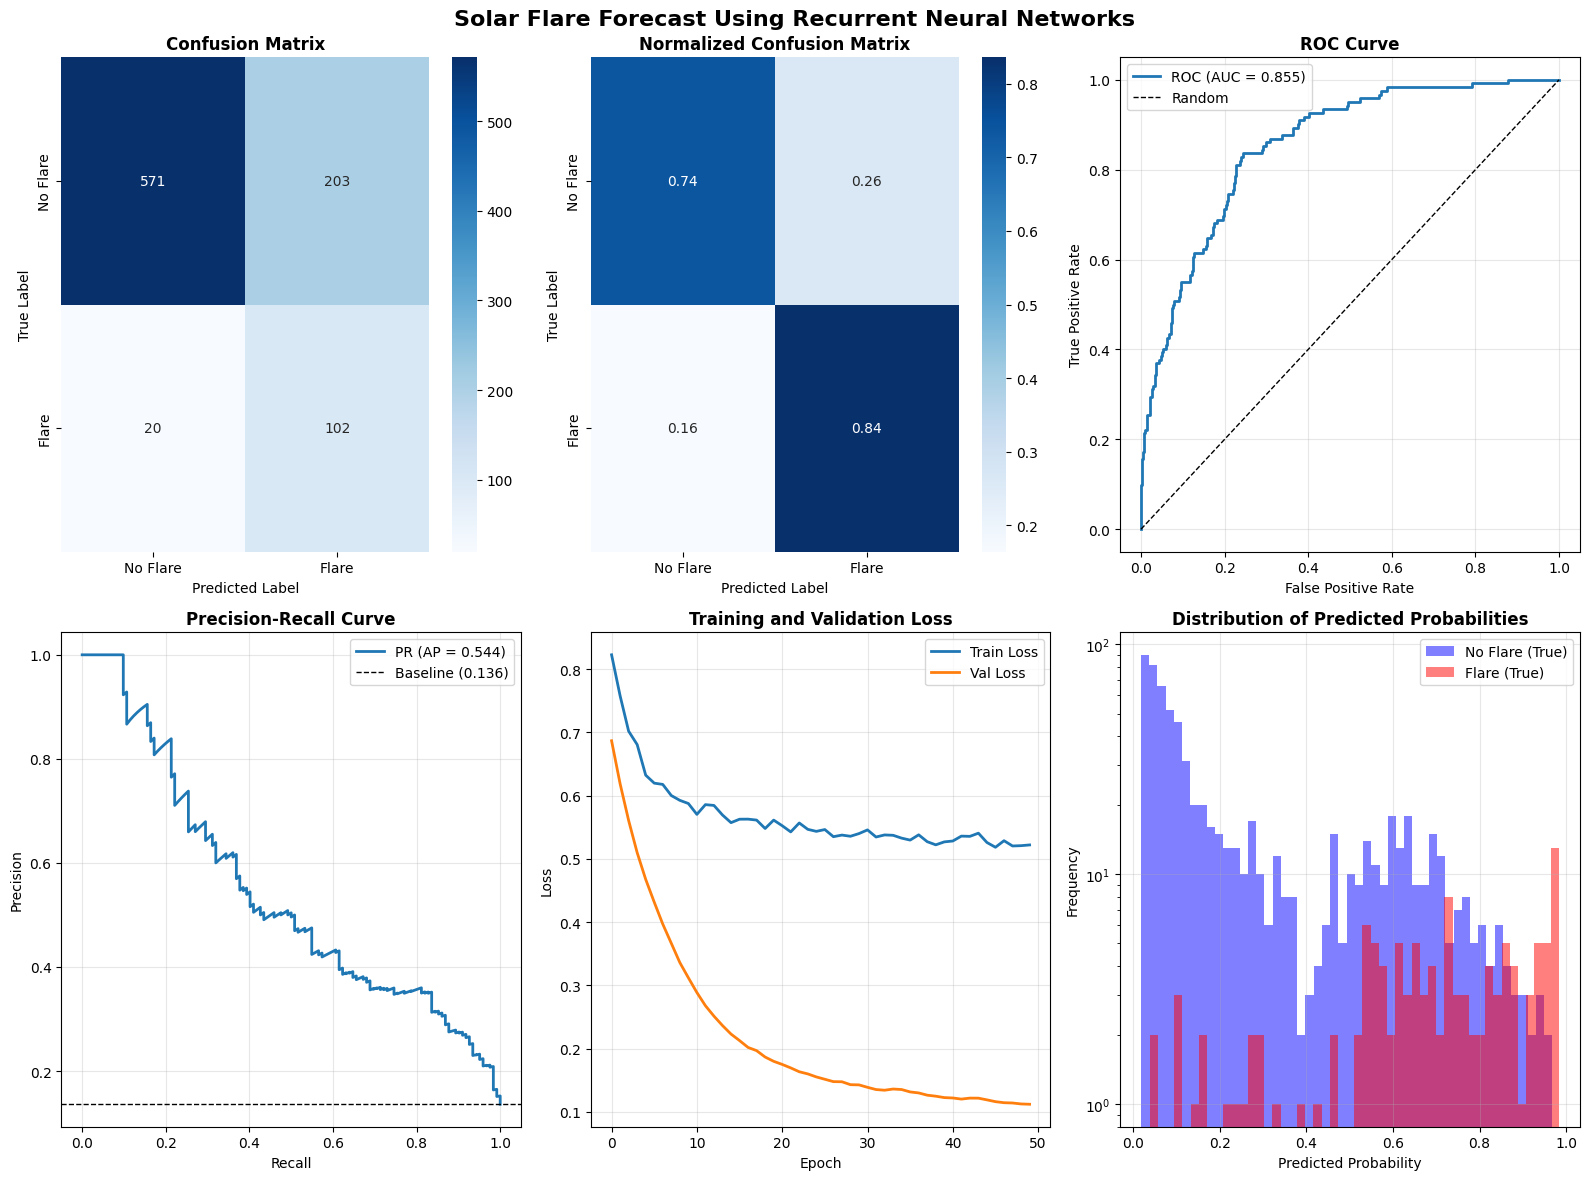

In [27]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Solar Flare Forecast Using Recurrent Neural Networks', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Training and Validation Loss
if 'history' in locals():
    hist = history.history
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax5.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/solar_flare_RNN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_RNN_results.png'")
plt.show()